In [1]:
import numpy as np, pandas as pd, math, torch
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial
%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Graph Convolutional Networks

## Load data

In [3]:
path = Path('data/cora')

In [4]:
paper_features_label = np.genfromtxt(path/'cora.content', dtype=np.str)
paper_features_label
# <paper_id> <word_attributes>+ <class_label>

array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
       ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
       ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
       ...,
       ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
       ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
       ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
      dtype='<U22')

In [5]:
from scipy.sparse import csr_matrix

features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
features

<2708x1433 sparse matrix of type '<class 'numpy.float32'>'
	with 3880564 stored elements in Compressed Sparse Row format>

In [6]:
labels = paper_features_label[:, -1]
lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
labels[:5]

[2, 5, 4, 4, 3]

In [7]:
papers = paper_features_label[:,0].astype(np.int32)
papers

array([  31336, 1061127, 1106406, ..., 1128978,  117328,   24043],
      dtype=int32)

In [8]:
paper2idx = {k:v for v,k in enumerate(papers)}
edges = np.genfromtxt(path/'cora.cites', dtype=np.int32)
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
edges
# <ID of cited paper> <ID of citing paper>

array([[ 163,  402],
       [ 163,  659],
       [ 163, 1696],
       ...,
       [1887, 2258],
       [1902, 1887],
       [ 837, 1686]], dtype=int32)

In [9]:
# Adjacency matrix
from scipy.sparse import coo_matrix

adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)
adj

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 5429 stored elements in COOrdinate format>

In [10]:
# Symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [11]:
from scipy.sparse import diags

def normalize(mx):
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [12]:
# Normalize features
features = normalize(features)

In [13]:
from scipy.sparse import eye

# Normalize and enforce self-loops in the graph
adj = normalize(adj + eye(adj.shape[0]))

In [14]:
# Transform adj matrix to torch sparse tensor
# adj = adj.tocoo().astype(np.float32)
# adj = torch.sparse_coo_tensor((adj.row, adj.col), adj.data, adj.shape)
# adj

In [15]:
# Data as tensors
adj = torch.FloatTensor(adj.todense())
features = torch.FloatTensor(features.todense())
labels = torch.LongTensor(labels)

## Tran val test split

In [16]:
np.random.seed(34)
n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
idxs = np.random.permutation(len(features))
idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

In [18]:
# gpu if available
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

## Model

In [26]:
from torch import nn
import torch.nn.functional as F

class GraphConvolution(nn.Module):
    def __init__(self, f_in, f_out, use_bias=True, activation=F.relu_):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        self.bias = nn.Parameter(torch.FloatTensor(f_out)) if use_bias else None
        self.initialize_weights()
        
    def initialize_weights(self):
        if self.activation is None: nn.init.xavier_uniform_(self.weight)
        else: nn.init.kaiming_uniform_(self.weight, nonlinearity='relu')
        if self.use_bias: nn.init.zeros_(self.bias)
        
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        # output = torch.spmm(adj, support) # In case of using sparse adj
        if self.use_bias: output.add_(self.bias)
        if self.activation is not None: self.activation(output)
        return output

class GCN(nn.Module):
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.5]):
        super().__init__()
        layers = []
        for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
            layers += [GraphConvolution(f_in, f_out)]
            
        self.layers = nn.Sequential(*layers)
        self.dropouts = dropouts
        self.out_layer = GraphConvolution(f_out, n_classes, activation=None)
        
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: F.dropout(x, d, training=self.training)
                
        return self.out_layer(x, adj)

In [27]:
n_labels = labels.max().item() + 1
n_features = features.shape[1]
n_labels, n_features

(7, 1433)

# Train

In [28]:
def accuracy(output,y):
    return (output.argmax(1) == y).type(torch.float32).mean().item()

def step():
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(features, adj)
    loss = F.cross_entropy(output[idx], labels[idx]).item()
    return loss, accuracy(output[idx], labels[idx])

In [29]:
lr = 1e-3
model = GCN(n_features, n_labels, hidden=[16, 32, 16], dropouts=[0.5, 0, 0.5]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=5e-4)

In [30]:
from tqdm.notebook import trange

epochs = 500
print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []
for i in trange(epochs):
    with torch.autograd.set_detect_anomaly(True): tl, ta = step()
#     tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]
    if (i+1)%print_steps == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]
        print(f'{i+1:6d}/{epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}'+
              f', val_loss={vl:.4f}, val_acc={va:.4f}')

     1/500: train_loss=1.9559, train_acc=0.1150, val_loss=1.9624, val_acc=0.1033
    50/500: train_loss=1.8479, train_acc=0.3850, val_loss=1.8657, val_acc=0.3000
   100/500: train_loss=1.5680, train_acc=0.6300, val_loss=1.6557, val_acc=0.5533
   150/500: train_loss=1.0789, train_acc=0.6750, val_loss=1.2820, val_acc=0.5700
   200/500: train_loss=0.6957, train_acc=0.7850, val_loss=0.9428, val_acc=0.6633
   250/500: train_loss=0.4078, train_acc=0.9300, val_loss=0.6995, val_acc=0.8033
   300/500: train_loss=0.2240, train_acc=0.9600, val_loss=0.6047, val_acc=0.8000
   350/500: train_loss=0.1352, train_acc=0.9900, val_loss=0.5955, val_acc=0.8033
   400/500: train_loss=0.0919, train_acc=0.9900, val_loss=0.6165, val_acc=0.8000
   450/500: train_loss=0.0654, train_acc=0.9950, val_loss=0.6418, val_acc=0.8000
   500/500: train_loss=0.0495, train_acc=1.0000, val_loss=0.6631, val_acc=0.7967



Train     : loss=0.0495, accuracy=1.0000
Validation: loss=0.6631, accuracy=0.7967
Test      : loss=0.8914, accuracy=0.7631



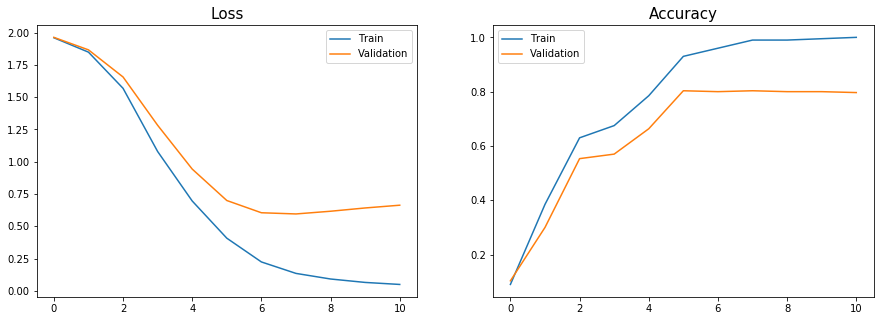

In [31]:
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
print(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
print(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')
print(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')
print()

fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')
for ax,t in zip(axes, ['Loss', 'Accuracy']): ax.legend(), ax.set_title(t, size=15)

## Output examples from test

In [32]:
output = model(features, adj)

In [33]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

,Real,Pred
0,Probabilistic_Methods,Case_Based
1,Genetic_Algorithms,Genetic_Algorithms
2,Neural_Networks,Neural_Networks
3,Theory,Theory
4,Reinforcement_Learning,Theory
5,Neural_Networks,Neural_Networks
6,Probabilistic_Methods,Probabilistic_Methods
7,Theory,Theory
8,Neural_Networks,Neural_Networks
9,Neural_Networks,Neural_Networks
